## TALL模型实现

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import torchvision
from torch.utils.data import DataLoader
from datetime import datetime  # 用于计算时间

import os
import sys
from collections import Counter
import re

#import tensorflow.contrib.keras as kr
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

from torchtext import data
import jieba

import cv2
import os

from torch.autograd import Variable
import tensorwatch as tw
import torchvision.models

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
torch.set_printoptions(precision=15)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
np.set_printoptions(threshold=np.inf)

from torch.optim import lr_scheduler

import time

## 数据准备

### 路径

In [3]:
train_path = 'C:/Users/wuxun/Desktop/Data/TALL/traning/training.txt'
val_path = 'C:/Users/wuxun/Desktop/Data/TALL/validation/validation.txt'
vocab_dir = 'C:/Users/wuxun/Desktop/Data/vocab.txt'
csv_path = 'D:/csv/'
save_path = 'C:/Users/wuxun/Desktop/Data/TALL/save_model/'
test_path = 'C:/Users/wuxun/Desktop/Data/TALL/testing/test.txt'

In [4]:
BATCH_SIZE = 1
EPOCH = 200

In [5]:
def read_vocab(vocab_dir):

    """读取词汇表"""

    with open(vocab_dir) as fp:
        words = [(_.strip()) for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [6]:
def get_dict(path, csv_path):
    '''
    获得最终的数据集
    path:文本数据集
    csv_path
    '''
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    target_csv=[]
    target_time_list=[]
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            target = List[4]
            
            #将句子转换为id表示：
            sentence = List[6].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            
            #确定时间点，前帧后帧取pooling
            target = target.split('_')
            cur_start = float(target[0])
            cur_end = float(target[1])
            middle_time = (cur_start + cur_end)//2
            
            #中间帧
            target_frame_num = int(middle_time/time_length*500)
            target_middle_frame = frame_sum.loc[target_frame_num]
            
            #上下文信息
            target_frame_start = int(cur_start/time_length*500)
            target_frame_end = int(cur_end/time_length*500)
            if target_frame_start == target_frame_num:
                print(str(cur_start)+"  "+str(cur_end)+" "+str(time_length))
                print("出现重复！")
                target_frame_start = min(target_frame_num - 3, 0)
            if  target_frame_end ==target_frame_num:
                print(str(cur_start)+"  "+str(cur_end)+" "+str(time_length))
                print("出现重复！")
                target_frame_start = min(target_frame_num + 3, 499)
                
            pre_context = np.zeros([target_frame_num - target_frame_start, 512], dtype=np.float32)
            post_context = np.zeros([target_frame_end - target_frame_num, 512], dtype=np.float32) 
            for i in range(target_frame_num - target_frame_start):
                pre_context[i] = frame_sum.loc[i]
                
            for i in range(target_frame_end - target_frame_num):
                post_context[i] = frame_sum.loc[i]
            
            #对pre_context和post_context取均值
            pre_context = np.mean(pre_context, axis=0)
            post_context = np.mean(post_context, axis=0)
            
            #对三段信息进行拼接
            image = np.hstack((pre_context, target_middle_frame, post_context))
            
            target_csv.append(image)
            target_time_list.append([cur_start, cur_end])
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0]*(Max_len-len(line)) 
                                            for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)    
    print(len(batch_seq),len(target_csv),len(target_time_list))
    
    return batch_seq, target_csv, target_time_list

### 读取数据

In [6]:
sentence_tarin_batch, target_train_csv, target_train_list = get_dict(train_path, csv_path)

106.0  107.0 219.22
出现重复！
50.0  51.0 244.37
出现重复！
87.0  88.0 244.37
出现重复！
30.0  31.0 129.24
出现重复！
258.0  259.0 396.3
出现重复！
31.0  32.0 88.22
出现重复！
51.0  52.0 271.07
出现重复！
1548 1548 1548


In [7]:
sentence_val_batch, target_val_csv, target_val_list = get_dict(val_path, csv_path)

146.0  148.0 561.49
出现重复！
262.0  263.0 352.4
出现重复！
183.0  184.0 329.89
出现重复！
281.0  282.0 349.68
出现重复！
523 523 523


In [7]:
def batch_iter(x_batch, target_csv, target_list, batch_size = 64):
    """
    生成批次数据
    """
    data_len = x_batch.shape[0]
    num_batch = int((data_len - 1) / batch_size) + 1
    indices = np.random.permutation(np.arange(data_len))
    
    x_batch_shuffle = x_batch[indices]
    y_csv_shuffle = np.array(target_csv)[indices]
    target_list = np.array(target_list)[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_batch_shuffle[start_id:end_id], y_csv_shuffle[start_id:end_id], target_list[start_id:end_id]

## 模型定义

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, mean=0, std=0.01)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data)
        m.bias.data.fill_(0)

In [9]:
class TALL(nn.Module):
    def __init__(self):
        super(TALL, self).__init__()
        self.semantic_size = 128 # the size of visual and semantic comparison size
        #self.sentence_embedding_size = 4800
        self.visual_feature_dim = 1536
        self.v2s_lt = nn.Linear(self.visual_feature_dim, self.semantic_size)#视觉提取
        self.s2s_lt = nn.Linear(256, 128)#句子提取
        self.fc1 = torch.nn.Conv2d(128*4, 128, kernel_size=1, stride=1)
        self.fc2 = torch.nn.Conv2d(128, 3, kernel_size=1, stride=1)
        # Initializing weights
        self.apply(weights_init)
        
        #self_add
        self.embedding = nn.Embedding(5000, 64)
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)

    def cross_modal_comb(self, visual_feat, sentence_embed):
        batch_size = visual_feat.size(0)
        #print("进入交叉阶段,batch_size = "+str(batch_size))

        vv_feature = visual_feat.expand([batch_size,batch_size,self.semantic_size])
        ss_feature = sentence_embed.repeat(1,1,batch_size).view(batch_size,batch_size,self.semantic_size)

        concat_feature = torch.cat([vv_feature, ss_feature], 2)

        mul_feature = vv_feature * ss_feature # 64,64,128
        add_feature = vv_feature + ss_feature # 64,64,128

        comb_feature = torch.cat([mul_feature, add_feature, concat_feature], 2)

        return comb_feature


    def forward(self, visual_feature_train, sentence_embed_train):
        transformed_clip_train = self.v2s_lt(visual_feature_train)
        transformed_clip_train_norm = F.normalize(transformed_clip_train, p=2, dim=1)
        
        sentence_embed_train = self.embedding(sentence_embed_train)
        sentence_embed_train,_ =self.lstm(sentence_embed_train)
        transformed_sentence_train = self.s2s_lt(sentence_embed_train[:,-1,:])
        transformed_sentence_train_norm = F.normalize(transformed_sentence_train, p=2, dim=1)
        
        cross_modal_vec_train = self.cross_modal_comb(transformed_clip_train_norm, transformed_sentence_train_norm)
        
        cross_modal_vec_train = cross_modal_vec_train.unsqueeze(0).permute(0, 3, 1, 2)
        mid_output = self.fc1(cross_modal_vec_train)
        mid_output = F.relu(mid_output)
        sim_score_mat_train = self.fc2(mid_output).squeeze(0)
        
        return sim_score_mat_train

## 回归阶段

In [10]:
TALL_model = TALL()
TALL_model.load_state_dict(torch.load(save_path + 'epoch665params.pkl'))
lr = 0.01
train_loss_list = []
val_loss_list = []
optimizer = torch.optim.Adam(TALL_model.parameters(), lr = lr)

In [17]:
def train(inital_epoch):
    # compute alignment and regression loss
    Max_loss = 1000
    print("start traning.......")
    for epoch in range(EPOCH):
        train_loss = 0
        loss_align_sum = 0
        loss_reg_sum = 0
        count = 0
        batch_train = batch_iter(sentence_tarin_batch, target_train_csv, target_train_list, BATCH_SIZE)
        begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        for x_batch, y_csv, target_time in batch_train:
            if y_csv.shape[0]==BATCH_SIZE:
                count += 1
                x = Variable(torch.LongTensor(x_batch))
                y = Variable(torch.FloatTensor(np.array(y_csv)))
                offsets = Variable(torch.FloatTensor(np.array(target_time)))
                outputs = TALL_model(y, x)
                sim_score_mat = outputs[0]
                p_reg_mat = outputs[1]
                l_reg_mat = outputs[2]
                # loss cls, not considering iou
                input_size = outputs.size(1)
                I = torch.eye(input_size)
                I_2 = -2 * I
                all1 = torch.ones(input_size, input_size)

                mask_mat = I_2 + all1  

                alpha = 1.0 / input_size
                lambda_regression = 0.01
                batch_para_mat = alpha * all1
                para_mat = I + batch_para_mat

                loss_mat = torch.log(all1 + torch.exp(mask_mat*sim_score_mat))
                loss_mat = loss_mat*para_mat
                loss_align = loss_mat.mean()

                # regression loss
                l_reg_diag = torch.mm(l_reg_mat*I, torch.ones(input_size, 1))
                p_reg_diag = torch.mm(p_reg_mat*I, torch.ones(input_size, 1))
                offset_pred = torch.cat([p_reg_diag, l_reg_diag], 1)
                loss_reg = torch.abs(offset_pred - offsets).mean() # L1 loss

                loss= lambda_regression*loss_reg +loss_align
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss
                loss_reg_sum += loss_reg
                loss_align_sum += loss_align
        
        current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        print(begin_time+' | '+current_time+' | '+('Epoch: %d | Loss: %.3f | loss_align: %.3f | loss_reg: %.3f' % (inital_epoch + epoch, train_loss / (count), loss_align_sum / (count), loss_reg_sum / (count))))
        train_loss_list.append(train_loss / (count))
        
        if (epoch + 1)%5 == 0:
            print("validation.....")
            val_loss = 0
            valloss_align_sum = 0
            valloss_reg_sum = 0
            count = 0
            batch_val = batch_iter(sentence_val_batch, target_val_csv, target_val_list, BATCH_SIZE)
            begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            for x_batch, y_csv, target_time in batch_val:
                if y_csv.shape[0]==BATCH_SIZE:
                    count += 1
                    x = Variable(torch.LongTensor(x_batch))
                    y = Variable(torch.FloatTensor(np.array(y_csv)))
                    offsets = Variable(torch.FloatTensor(np.array(target_time)))
                    outputs = TALL_model(y, x)
                    sim_score_mat = outputs[0]
                    p_reg_mat = outputs[1]
                    l_reg_mat = outputs[2]
                    input_size = outputs.size(1)
                    I = torch.eye(input_size)
                    I_2 = -2 * I
                    all1 = torch.ones(input_size, input_size)

                    mask_mat = I_2 + all1  

                    alpha = 1.0 / input_size
                    lambda_regression = 0.01
                    batch_para_mat = alpha * all1
                    para_mat = I + batch_para_mat

                    loss_mat = torch.log(all1 + torch.exp(mask_mat*sim_score_mat))
                    loss_mat = loss_mat*para_mat
                    loss_align = loss_mat.mean()

                    # regression loss
                    l_reg_diag = torch.mm(l_reg_mat*I, torch.ones(input_size, 1))
                    p_reg_diag = torch.mm(p_reg_mat*I, torch.ones(input_size, 1))
                    offset_pred = torch.cat([p_reg_diag, l_reg_diag], 1)
                    loss_reg = torch.abs(offset_pred - offsets).mean() # L1 loss

                    loss= lambda_regression*loss_reg +loss_align
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    val_loss += loss
                    valloss_reg_sum += loss_reg
                    valloss_align_sum += loss_align
            
            current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            print(begin_time+' | '+current_time+' | '+('Epoch: %d | Loss: %.3f | loss_align: %.3f | loss_reg: %.3f' % (inital_epoch + epoch, val_loss / (count), valloss_align_sum / (count), valloss_reg_sum / (count))))
            val_loss_list.append(val_loss / (count))
            torch.save(TALL_model.state_dict(), save_path + 'epoch'+str(inital_epoch + epoch)+'params.pkl')
            if val_loss / count < Max_loss:
                Max_loss = val_loss / count
                print("model save!")

In [18]:
train(665)

start traning.......
2020-08-15 19:01:41 | 2020-08-15 19:02:51 | Epoch: 665 | Loss: 0.069 | loss_align: 0.000 | loss_reg: 6.935
2020-08-15 19:02:51 | 2020-08-15 19:04:06 | Epoch: 666 | Loss: 0.065 | loss_align: 0.000 | loss_reg: 6.463
2020-08-15 19:04:06 | 2020-08-15 19:05:18 | Epoch: 667 | Loss: 0.067 | loss_align: 0.000 | loss_reg: 6.666
2020-08-15 19:05:18 | 2020-08-15 19:06:28 | Epoch: 668 | Loss: 0.065 | loss_align: 0.000 | loss_reg: 6.475
2020-08-15 19:06:28 | 2020-08-15 19:07:38 | Epoch: 669 | Loss: 0.063 | loss_align: 0.000 | loss_reg: 6.345
validation.....
2020-08-15 19:07:38 | 2020-08-15 19:08:02 | Epoch: 669 | Loss: 0.131 | loss_align: 0.000 | loss_reg: 13.112
model save!
2020-08-15 19:08:02 | 2020-08-15 19:09:13 | Epoch: 670 | Loss: 0.066 | loss_align: 0.000 | loss_reg: 6.632
2020-08-15 19:09:13 | 2020-08-15 19:10:23 | Epoch: 671 | Loss: 0.066 | loss_align: 0.000 | loss_reg: 6.620
2020-08-15 19:10:23 | 2020-08-15 19:11:34 | Epoch: 672 | Loss: 0.064 | loss_align: 0.000 | los

KeyboardInterrupt: 

## 绘制曲线

In [19]:
def draw(train_loss_list, val_loss_list):
    x1 = range(0, len(train_loss_list))
    x2 = range(0, len(val_loss_list))
    #with plt.style.context(['science']):
    plt.subplot(2, 1, 1)
    plt.plot(x1, train_loss_list[:len(train_loss_list)], 'o-')
    plt.title('train loss vs. epoches')
    plt.ylabel('train loss')
    plt.subplot(2, 1, 2)
    plt.plot(x2,val_loss_list[:len(val_loss_list)] , '.-')
    plt.xlabel('Val loss vs. epoches')
    plt.ylabel('Val loss')
    plt.show()

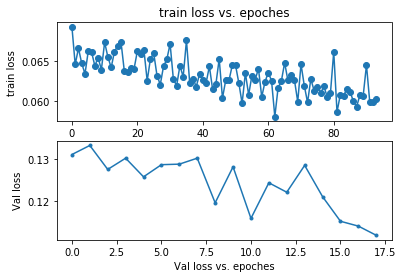

In [20]:
draw(train_loss_list, val_loss_list)
torch.save(TALL_model.state_dict(), save_path + 'final_model_params.pkl')

## 对比计算

In [11]:
# 定义LSTM的结构
class LSTM_CNN(nn.Module):
    
    def __init__(self):
        super(LSTM_CNN, self).__init__()
        
        self.embedding = nn.Embedding(5000, 64)
        self.rnn = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        #self.rnn = nn.GRU(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        self.f1 = nn.Sequential(nn.Linear(256,128),
                                nn.Dropout(0.8),
                                nn.ReLU())

        self.f2 = nn.Sequential(nn.Linear(128,64))
        
        
        self.conv1=torch.nn.Sequential(
            torch.nn.Conv1d(1,10,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
        )
        
        self.conv2=torch.nn.Sequential(
            torch.nn.Conv1d(10,20,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
        )

        #self.fc1=torch.nn.Linear(2520,128)
        self.fc1=torch.nn.Linear(512,128)
        self.fc1_drop=torch.nn.Dropout(p=0.4)
        self.fc2=torch.nn.Linear(128, 64)
        
        #特征融合
        self.final_fc = nn.Linear(in_features=128, out_features=64)
        self.score_fc = torch.nn.Conv2d(64,3,kernel_size=1,stride=1)
        
        
    def cnnout(self, x2):
        in_fc=x2.view(x2.size(0),-1)
        out_fc1=self.fc1(in_fc)
        out_drop=self.fc1_drop(out_fc1)
        out_fc2=self.fc2(out_drop)
        return out_fc2
        
    def forward(self, x1, x2): 
        if x1.shape[0]!=2:
            #lstm
            x = self.embedding(x1)
            x,_ = self.rnn(x)
            x = F.dropout(x,p=0.8)
            
            x = self.f1(x[:,-1,:])
            lstm_output = self.f2(x)
            cnn_out=self.cnnout(x2)
            #concat
            output = torch.cat((lstm_output, cnn_out), 1)
            output = self.final_fc(output)
            return output
        else:
            cnn_out=self.cnnout(x2)
            return cnn_out

In [12]:
# 定义LSTM的结构
class Change(nn.Module):
    def __init__(self):
        super(Change, self).__init__()
        #特征融合
        self.score_fc = torch.nn.Conv1d(64, 2, kernel_size=1, stride=1)
        
    def forward(self, x):
        output = x#[10, 64]
        output = output.unsqueeze(2)
        score = self.score_fc(output)
        offset_pred = score.squeeze(2)
        return offset_pred

#### 加载模型

In [15]:
TALL_final_model = TALL()
My_model = Change()
middle_model = LSTM_CNN()
TALL_final_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/TALL/save_model/epoch754params.pkl'))
middle_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/189epoch_20200713_64_dim_params.pkl'))
My_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model2/新训练的model1以后训练model2无alignment/513.pkl'))

RuntimeError: Error(s) in loading state_dict for Change:
	size mismatch for score_fc.weight: copying a param with shape torch.Size([2, 128, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1]).

#### 固定模型

In [14]:
My_model.eval()
middle_model.eval()
TALL_final_model.eval()

TALL(
  (v2s_lt): Linear(in_features=1536, out_features=128, bias=True)
  (s2s_lt): Linear(in_features=256, out_features=128, bias=True)
  (fc1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (fc2): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
  (embedding): Embedding(5000, 64)
  (lstm): LSTM(64, 128, num_layers=2, bidirectional=True)
)

#### 功能函数

In [23]:
IoU_thresh = [0.1, 0.3, 0.5, 0.7]

In [24]:
def calculate_IoU(i0, i1):
    # calculate temporal intersection over union
    union = (min(i0[0], i1[0]), max(i0[1], i1[1]))
    inter = (max(i0[0], i1[0]), min(i0[1], i1[1]))
    iou = 1.0*(inter[1]-inter[0])/(union[1]-union[0])
    return iou

In [25]:
def compute_IoU_recall_top_n_forreg(iou_thresh, time_mat, time_pre_mat):#top
    correct_num = 0
    for i in range(time_mat.shape[0]):
        gt_start = time_mat[i][0]
        gt_end = time_mat[i][1]
        pred_start = time_pre_mat[i][0]
        pred_end = time_pre_mat[i][1]
        iou = calculate_IoU((gt_start, gt_end),(pred_start, pred_end))
        if iou>=iou_thresh:
            correct_num+=1
    return correct_num

In [26]:
def pred_for_TALL(outputs):
    p_reg_mat = outputs[1]
    l_reg_mat = outputs[2]
    input_size = outputs.size(1)
    I = torch.eye(input_size)
    l_reg_diag = torch.mm(l_reg_mat*I, torch.ones(input_size, 1))
    p_reg_diag = torch.mm(p_reg_mat*I, torch.ones(input_size, 1))
    offset_pred = torch.cat([p_reg_diag, l_reg_diag], 1)
    return offset_pred

In [27]:
# 读取test数据集
def get_test_dict_for_TALL(path, csv_path):
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    csv=[]
    time_list=[]
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            target = List[4]
            
            #将句子转换为id表示：
            sentence = List[5].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            
            #确定时间点，前帧后帧取pooling
            target = target.split('_')
            cur_start = float(target[0])
            cur_end = float(target[1])
            middle_time = (cur_start + cur_end)//2
            
            #中间帧
            target_frame_num = int(middle_time/time_length*500)
            target_middle_frame = frame_sum.loc[target_frame_num]
            
            #上下文信息
            target_frame_start = int(cur_start/time_length*500)
            target_frame_end = int(cur_end/time_length*500)
            if target_frame_start == target_frame_num:
                print(str(cur_start)+"  "+str(cur_end)+" "+str(time_length))
                print("出现重复！")
                target_frame_start = min(target_frame_num - 3, 0)
            if  target_frame_end ==target_frame_num:
                print(str(cur_start)+"  "+str(cur_end)+" "+str(time_length))
                print("出现重复！")
                target_frame_start = min(target_frame_num + 3, 499)
                
            pre_context = np.zeros([target_frame_num - target_frame_start, 512], dtype=np.float32)
            post_context = np.zeros([target_frame_end - target_frame_num, 512], dtype=np.float32) 
            for i in range(target_frame_num - target_frame_start):
                pre_context[i] = frame_sum.loc[i]
                
            for i in range(target_frame_end - target_frame_num):
                post_context[i] = frame_sum.loc[i]
            
            #对pre_context和post_context取均值
            pre_context = np.mean(pre_context, axis=0)
            post_context = np.mean(post_context, axis=0)
            
            #对三段信息进行拼接
            image = np.hstack((pre_context, target_middle_frame, post_context))
            
            csv.append(image)
            time_list.append([cur_start, cur_end])
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0]*(Max_len-len(line)) 
                                            for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)    
    print(len(batch_seq),len(csv),len(time_list))
    
    return batch_seq, csv, time_list

In [28]:
#读取test集
# 读取test数据集
def get_test_dict_for_My_model(path, csv_path):
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    csv=[]
    time_list=[]
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            target = List[4]
            
            #将句子转换为id表示：
            sentence = List[6].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            
            #确定时间点，前帧后帧取pooling
            target = target.split('_')
            cur_start = float(target[0])
            cur_end = float(target[1])
            middle_time = (cur_start + cur_end)//2
            
            #中间帧
            target_frame_num = int(middle_time/time_length*500)
            target_middle_frame = frame_sum.loc[target_frame_num]
            
            csv.append(target_middle_frame)
            time_list.append([cur_start, cur_end])
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0]*(Max_len-len(line)) 
                                            for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)    
    print(len(batch_seq),len(csv),len(time_list))
    
    return batch_seq, csv, time_list

#### 读取test集

In [29]:
TALL_test_seq, TALL_test_csv, TALL_test_time_list = get_test_dict_for_TALL(test_path, csv_path)

894.0  896.0 1106.12
出现重复！
132 132 132


In [44]:
# My_test_seq, My_test_csv, My_test_time_list = get_test_dict_for_My_model(test_path, csv_path)

#### TALL计算

In [30]:
x = Variable(torch.LongTensor(TALL_test_seq))
y = Variable(torch.FloatTensor(np.array(TALL_test_csv)))
TALL_time_mat = Variable(torch.FloatTensor(np.array(TALL_test_time_list)))
TALL_outputs = TALL_final_model(y, x)
TALL_pre_time_mat = pred_for_TALL(TALL_outputs)

In [31]:
for iou_thresh in IoU_thresh:
    corrnum = compute_IoU_recall_top_n_forreg(iou_thresh, TALL_time_mat, TALL_pre_time_mat)
    corr_avg = corrnum*1.0 / TALL_time_mat.shape[0] 
    print("TALL: R@1 for iou_thresh: %.1f is : %.3f" % (iou_thresh, corr_avg))

TALL: R@1 for iou_thresh: 0.1 is : 0.114
TALL: R@1 for iou_thresh: 0.3 is : 0.076
TALL: R@1 for iou_thresh: 0.5 is : 0.015
TALL: R@1 for iou_thresh: 0.7 is : 0.000


#### My_model计算

In [187]:
x = Variable(torch.LongTensor(My_test_seq))
y = Variable(torch.FloatTensor(np.array(My_test_csv)))
My_time_mat = Variable(torch.FloatTensor(np.array(My_test_time_list)))
My_output1 = middle_model(x, y)
My_pred_time_mat = My_model(My_output1)

In [188]:
for iou_thresh in IoU_thresh:
    corrnum = compute_IoU_recall_top_n_forreg(iou_thresh, My_time_mat, My_pred_time_mat)
    corr_avg = corrnum*1.0 / My_time_mat.shape[0] 
    print("My_model: R@1 for iou_thresh: %.1f is : %.3f" % (iou_thresh, corr_avg))

My_model: R@1 for iou_thresh: 0.1 is : 0.114
My_model: R@1 for iou_thresh: 0.3 is : 0.038
My_model: R@1 for iou_thresh: 0.5 is : 0.015
My_model: R@1 for iou_thresh: 0.7 is : 0.000
